# <center>Home Credit Default Risk<center>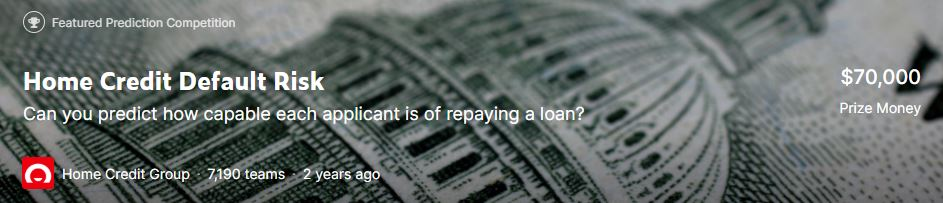  
# <center>Naya classification project #4</center>

# **<center>Ori Bein & Ori Roval</center>**




   


**<center>This project is the middle submission, classification assignment, at the course: Data Science in Naya College<center>**

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from numpy import where
from mpl_toolkits.mplot3d import axes3d



In [ ]:
ap_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
ap_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
# print(ap_train.shape, '_', ap_test.shape)

#final data set for model
ap_trainf=ap_train.copy()

# **EDA**

## Introduction
**Application Train - Dataset**

This project data-set was taken from Kaggle compatition.
https://www.kaggle.com/c/home-credit-default-risk/discussion/57054

In this project **only the competition main data set- application - is used**.  
The data includes information from 307,511 loans, with an 8.4% default rate. The goal is to predict probability of default for each loan.

Competition score is measured using the area under ROC curve.


## General Data Visualization
1. Missing values
2. Distributions


In [ ]:
# Presentation
# ap_trainf.iloc[:,[0,1,4,40,41,42,55,65,95,96,119]].info()

In [ ]:
# 1
plt.figure(figsize = (8,24))
sns.heatmap(pd.DataFrame(ap_train.isnull().sum()/ap_train.shape[0]*100),annot=True,
            cmap=sns.color_palette("Blues_d",10),linewidth=1,linecolor="white")
plt.title("application nulls")

plt.subplots_adjust(wspace = 1.6)

The data includes 7 data sectiones:



1.   Loan information.
2.  Cliante detailes, mainly categorical fitcheres describing cliante social and financial status,also the day and the time cliante aproched.
3.   Data from 3 External Credit Due-Diligence companies evaluating cliante risk.
4.   Data from external database giving normalized information about building where the client lives.
1.   Cliantes Social Circle - number of cliant social connectiones that took a loan from company.
2.   Flag for 20 documantes cliante submited.
1.   Information on inquires done on cliante at financiale data sorce.

In [ ]:
# 2
apNum=ap_train.iloc[:,5:41].select_dtypes(include=['int64','float64'])
hist = apNum.hist(bins=10,figsize=(20,15))

## Data Cleaning
 


Droping 'FLAG_CONT_MOBILE' and 'FLAG_MOBIL' - both has same value for all data (or 99.8% of data).

In [ ]:
ap_trainf.drop(columns=['FLAG_CONT_MOBILE','FLAG_MOBIL'],inplace=True)
ap_test.drop(columns=['FLAG_CONT_MOBILE','FLAG_MOBIL'],inplace=True)

# Feature engineering


## Loan information & Cliantes detailes


### Seting up sugnificant ratioes

1. 'DAYS_EMPLOYED' has a set value (365243) both for Unemployed and Pensioner Income type, it is changed to values that represents the default probability of each group.
2. Loan to Income ratio - setting a ratio that represent how much of a borower income
3. Days Employed ratio - 'DAYS_EMPLOYED' to 'DAYS_BIRTH' (Age)

In [ ]:
# 1 
ap_trainf['DAYS_EMPLOYED'].loc[ap_trainf['DAYS_EMPLOYED']==365243] = np.where((ap_trainf['NAME_INCOME_TYPE'].loc[ap_trainf['DAYS_EMPLOYED']==365243] == 'Pensioner'), -4500, 0)
ap_test['DAYS_EMPLOYED'].loc[ap_test['DAYS_EMPLOYED']==365243] = np.where((ap_test['NAME_INCOME_TYPE'].loc[ap_test['DAYS_EMPLOYED']==365243] == 'Pensioner'), -4500, 0)
# ap_trainf['DAYS_EMPLOYED'].hist(bins=100)
# 2
ap_trainf['inc_ratio'] = round(ap_trainf['AMT_ANNUITY'] / ap_trainf['AMT_INCOME_TOTAL'],2) 
ap_test['inc_ratio'] = round(ap_test['AMT_ANNUITY'] / ap_test['AMT_INCOME_TOTAL'],2) 
# 3
ap_trainf['days_emp_ratio']=ap_trainf['DAYS_EMPLOYED'].div(ap_trainf['DAYS_BIRTH'])
ap_test['days_emp_ratio']=ap_test['DAYS_EMPLOYED'].div(ap_test['DAYS_BIRTH'])

ap_trainf['rtv_ratio'] = ap_trainf['AMT_ANNUITY'] / ap_trainf['AMT_GOODS_PRICE']
ap_test['rtv_ratio'] = ap_test['AMT_ANNUITY'] / ap_test['AMT_GOODS_PRICE']

ap_trainf['ltv_ratio'] = ap_trainf['AMT_CREDIT'] / ap_trainf['AMT_GOODS_PRICE']
ap_test['ltv_ratio'] = ap_test['AMT_CREDIT'] / ap_test['AMT_GOODS_PRICE']


In [ ]:
plt.figure(figsize = (12, 5))
# iterate through the new features
for i, feature in enumerate(['rtv_ratio','ltv_ratio']):
    
    # create a new subplot for each source
    plt.subplot(1, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(ap_trainf.loc[ap_trainf['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(ap_trainf.loc[ap_trainf['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Uniforming the total income destribution to help model

In [ ]:
ap_trainf['AMT_INCOME_TOTAL'].loc[ap_trainf['AMT_INCOME_TOTAL']>800000]=800000
log_income = np.log1p(ap_trainf.AMT_INCOME_TOTAL)
ap_trainf['AMT_log_INCOME_TOTAL'] = log_income
ap_trainf.drop(columns=['AMT_INCOME_TOTAL'],inplace=True)


ap_test['AMT_INCOME_TOTAL'].loc[ap_test['AMT_INCOME_TOTAL']>800000]=800000
log_income = np.log1p(ap_test.AMT_INCOME_TOTAL)
ap_test['AMT_log_INCOME_TOTAL'] = log_income
ap_test.drop(columns=['AMT_INCOME_TOTAL'],inplace=True)
# ap_trainf.AMT_log_INCOME_TOTAL.hist(bins=100)

### UNITING_TYPE & OCCUPATION_TYPE  
'OCCUPATION_TYPE' is a sub category of 'NAME_INCOME_TYPE' and also has Null for 30% of values 

In [ ]:
#  Train
ap_trainf['OCCUPATION_TYPE'].fillna(('Gen'), inplace=True)
ap_trainf['OCCUPATION_TYPE'] = ap_trainf['NAME_INCOME_TYPE'] + '_' + ap_trainf['OCCUPATION_TYPE']
ap_trainf.drop(columns=['NAME_INCOME_TYPE'],inplace=True)

# Test
ap_test['OCCUPATION_TYPE'].fillna(('Gen'), inplace=True)
ap_test['OCCUPATION_TYPE'] = ap_test['NAME_INCOME_TYPE'] + '_' + ap_test['OCCUPATION_TYPE']
ap_test.drop(columns=['NAME_INCOME_TYPE'],inplace=True)

In [ ]:
# converting occupation type to default rate
occ_t = pd.DataFrame(ap_trainf.loc[:,['OCCUPATION_TYPE','TARGET']].groupby('OCCUPATION_TYPE')['TARGET'].agg(Mean='mean', Count='count'))
ap_trainf['OCCUPATION_TYPE'] = ap_trainf['OCCUPATION_TYPE'].map(occ_t['Mean'])
# Test
ap_test['OCCUPATION_TYPE'] = ap_test['OCCUPATION_TYPE'].map(occ_t['Mean'])

### Car Owners
1. 5 Rows have both Y (Yes) for owned car and no car age, so we use MODE of all car ages to complete it. 
2. Creating bins for car age (including no car as a separate bin).
3. Converting to car age to dummies.
4. Dropping original OWN_CAR_AGE','FLAG_OWN_CAR' features.

In [ ]:
# 1 
ap_trainf.OWN_CAR_AGE.loc[(ap_trainf.OWN_CAR_AGE.isnull()) & (ap_trainf.FLAG_OWN_CAR == 'Y')] = float(ap_trainf.OWN_CAR_AGE.loc[ap_trainf.OWN_CAR_AGE.notnull()].mode())
# 2
ap_trainf.OWN_CAR_AGE.loc[ap_trainf.OWN_CAR_AGE.isnull()] = (-1)
ap_trainf['car'] = pd.cut(x=ap_trainf['OWN_CAR_AGE'], bins=[-2,-0.1,8,11,100],labels=['no' ,'new','reg','old'])
# ap_trainf.groupby('car')['TARGET'].agg(['mean','count'])
# 3
ap_trainf = pd.get_dummies(data=ap_trainf, columns=['car'],drop_first=True)
# 4
ap_trainf = ap_trainf.drop(columns=['FLAG_OWN_CAR','OWN_CAR_AGE'])



In [ ]:
# 1 
ap_test.OWN_CAR_AGE.loc[(ap_test.OWN_CAR_AGE.isnull()) & (ap_test.FLAG_OWN_CAR == 'Y')] = float(ap_test.OWN_CAR_AGE.loc[ap_test.OWN_CAR_AGE.notnull()].mode())
# 2
ap_test.OWN_CAR_AGE.loc[ap_test.OWN_CAR_AGE.isnull()] = (-1)
ap_test['car'] = pd.cut(x=ap_test['OWN_CAR_AGE'], bins=[-2,-0.1,8,11,100],labels=['no' ,'new','reg','old'])
# ap_trainf.groupby('car')['TARGET'].agg(['mean','count'])
# 3
ap_test = pd.get_dummies(data=ap_test, columns=['car'],drop_first=True)
# 4
ap_test = ap_test.drop(columns=['FLAG_OWN_CAR','OWN_CAR_AGE'])

### Replacing columns of categorical data with category probability


In [ ]:
#Spliting to work only with left part of th DF that includes clientes categorical data
apL=ap_trainf.iloc[:,0:44]
apLob=apL.select_dtypes(include='object')
apLob.fillna(value='NA',inplace=True)
apLob.head(5)

Replacing object data type at 8 columns with more then 3 cateories.
The object data is replaced with numeric value found from the sub category probability for default

In [ ]:
apLob.drop(['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_REALTY'],axis=1,inplace=True)
ocn=apLob.columns
apLob['TARGET']=ap_train['TARGET']
object_to_probability_dic={}
for CN in ocn:
   temp_PV=apLob.pivot_table(index=CN, values='TARGET', aggfunc={'TARGET': [sum, len]})
   temp_PV['Ratio of 1']=temp_PV['sum']/temp_PV['len']
   temp_PV.sort_values(['Ratio of 1'],inplace=True)
   temp_PV_sort=temp_PV.reindex()
   temp=list(range(len(temp_PV_sort.index)))
   #print(temp)
   object_to_probability_dic[CN] = dict(zip(temp_PV.index, temp))
print(object_to_probability_dic)

In [ ]:
for CN in ocn:
    ap_trainf.loc[:, CN] = ap_trainf[CN].replace(object_to_probability_dic[CN])
    ap_test.loc[:, CN] = ap_test[CN].replace(object_to_probability_dic[CN])
# ap_trainf.loc[:, ocn].head()

## External Rating

---

The 3 External Rating features found to be very meaningful

Thire for the 3 different external credit ratings are process to improve thire value, engineering 5 more features from them.




In [ ]:
 fig = plt.figure(figsize=(18,6))

 ax1 = fig.add_subplot(131)
 ax2 = fig.add_subplot(132)
 ax3 = fig.add_subplot(133)
 ap_train.plot('EXT_SOURCE_1', 'EXT_SOURCE_2', kind='scatter',ax=ax1,
           xlim=[0, 1], ylim=[0, 1],
           c=where(ap_train.TARGET==1, 'blue', 'pink'),
           s=1)
 ap_train.plot('EXT_SOURCE_1', 'EXT_SOURCE_3', kind='scatter',ax=ax2,
           xlim=[0, 1], ylim=[0, 1],
           c=where(ap_train.TARGET==1, 'blue', 'pink'),
           s=1)
 ap_train.plot('EXT_SOURCE_3', 'EXT_SOURCE_2', kind='scatter',ax=ax3,
           xlim=[0, 1], ylim=[0, 1],
           c=where(ap_train.TARGET==1, 'blue', 'pink'),
           s=1)

The blue dots representes cliant with default flag.
We can see bad corelation between the sourcess(the dots scater has shape of squre far from a diagonal line).
Thire is good corelation between low grade and higher rate of default cases.
It lookes that when cliant got highe score from at least two sourcess , thire only few default cases.
It lookes that EXT-2 predictiones are not that good, thire are many cliantes with highe score that got default flag.
Having that in mind we set 3 new features, and avoiding Null:
1. Minimum grade of cliant.
2. Maximum grade of cliant.
3. Multiple of EXT-1 and EXT-3 to emphasies the beter predictiones they have.
3. In case mean out of the 3 is lower then p (diffult 0.5 tested and found 0.25 is better), the grade is the mean grade,else the grade is the maximum grade out of the 3. 
In order to amplify the fitcher, the grade is transfared threw a Sigmoid function.

The new feature was diffaine as an transformer function that receives two argumants: g - the gaine of the sigmoid function, and p - defines minimum grade.

The two parameters can later be optimized using a grid search function.

In [ ]:
def ext_source_mul31_2(X):
  Ext_source=X.loc[:,['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
  Ext_source['EXT_SOURCE_7']=Ext_source['EXT_SOURCE_3'].mul(Ext_source['EXT_SOURCE_1'])
  #incase NA at 1 or 3 use 3^2 if 3 NA use 1^2 if 1 and 3 NA use 2^2
  Ext_source['EXT_SOURCE_7'].loc[Ext_source['EXT_SOURCE_7'].isna()]=Ext_source['EXT_SOURCE_3'].pow(2)
  Ext_source['EXT_SOURCE_7'].loc[Ext_source['EXT_SOURCE_7'].isna()]=Ext_source['EXT_SOURCE_1'].pow(2)
  Ext_source['EXT_SOURCE_7'].loc[Ext_source['EXT_SOURCE_7'].isna()]=Ext_source['EXT_SOURCE_2'].pow(2)
  #This features is very cruel to midle score customeres, thire for score will be mul by 4, and squared
  #Ext_source['EXT_SOURCE_7']=Ext_source['EXT_SOURCE_7'].mul(4).pow(0.5)
  return Ext_source['EXT_SOURCE_7']

In [ ]:
#Sigmoid function with gaine of g - at x=p sigmoid=0.5
def sigmoid(x,g,p):
  return 1/(1 + math.exp(-g*(-p+x)))


def ext_source_feature(X, g=6,p=0.5):
  Ext_source=X.loc[:,['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
  Ext_source['EXT_SOURCE_4']=Ext_source.mean(axis=1, skipna=True)
  Ext_source['EXT_SOURCE_5']=Ext_source.max(axis=1, skipna=True)
  Ext_source.loc[Ext_source['EXT_SOURCE_4'] < p,'EXT_SOURCE_6'] = Ext_source['EXT_SOURCE_4']
  Ext_source.loc[Ext_source['EXT_SOURCE_4'] >= p,'EXT_SOURCE_6'] = Ext_source['EXT_SOURCE_5']
  return Ext_source['EXT_SOURCE_6'].apply(sigmoid,args=(g,p))


Because EXT_3 lookes as a very good predictor, compose features from EXT_3 in case ECT_3 is null use EXT_1 in case EXT_1 is null use EXT_2

In [ ]:
def ext_source_312(X):
  Ext_source=X.loc[:,['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
  Ext_source['EXT_SOURCE_7']=Ext_source['EXT_SOURCE_3']
  Ext_source['EXT_SOURCE_7'].loc[Ext_source['EXT_SOURCE_3'].isna()]=Ext_source['EXT_SOURCE_1']
  Ext_source['EXT_SOURCE_7'].loc[Ext_source['EXT_SOURCE_7'].isna()]=Ext_source['EXT_SOURCE_2']
  return Ext_source['EXT_SOURCE_7']

In [ ]:
f_source = FunctionTransformer(ext_source_feature, validate=False, kw_args={'g': 6, 'p': 0.25})

f312_source = FunctionTransformer(ext_source_312, validate=False)

mul31_2_source = FunctionTransformer(ext_source_mul31_2, validate=False)


After applaying transformation only 172 cliants, 0.05% of data, have no grade data

In [ ]:

ap_trainf['EXT_SOURCE_f1']=f_source.transform(ap_train)
ap_trainf['EXT_SOURCE_312']=f312_source.transform(ap_train)
#ap_trainf['EXT_SOURCE_mul31_2']=mul31_2_source.transform(ap_train)
Ext_source=ap_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
ap_trainf['EXT_SOURCE_min']=Ext_source.min(axis=1, skipna=True)
ap_trainf['EXT_SOURCE_max']=Ext_source.max(axis=1, skipna=True)
#We should consider droping this very sagnificant features
#ap_trainf.drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],inplace=True)

# Test
ap_test['EXT_SOURCE_f1']=f_source.transform(ap_test)
ap_test['EXT_SOURCE_312']=f312_source.transform(ap_test)
#ap_test['EXT_SOURCE_mul31_2']=mul31_2_source.transform(ap_test)
Ext_source=ap_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
ap_test['EXT_SOURCE_min']=Ext_source.min(axis=1, skipna=True)
ap_test['EXT_SOURCE_max']=Ext_source.max(axis=1, skipna=True)

#ap_test.drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],inplace=True)

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ap_train.plot('EXT_SOURCE_3', 'EXT_SOURCE_2', kind='scatter',ax=ax1,
           xlim=[0, 1], ylim=[0, 1],
           c=where(ap_train.TARGET==1, 'navy', 'moccasin'),
           s=1)

ap_trainf.plot('EXT_SOURCE_f1', 'EXT_SOURCE_312', kind='scatter',ax=ax2,
          xlim=[0, 1], ylim=[0, 1],          
          c=where(ap_trainf.TARGET==1, 'navy', 'moccasin'),
          s=1)

## Enquiries to Credit Bureau
1. Creating 0,1 bins for 'AMT_REQ_CREDIT_BUREAU_DAY' and 'AMT_REQ_CREDIT_BUREAU_MON'.  
Both features remained due to negative correlaiton), other had little info regarding TARGET.
2. Creating dummy for nulls (all rows with null had null for all bureau enquiries).
4. Dropping all original AMT_REQ_CREDIT_BUREAU features.

In [ ]:
# 1
ap_trainf['BUR_DAY'] = pd.cut(x=ap_trainf['AMT_REQ_CREDIT_BUREAU_DAY'], bins=[-1,0,10],labels=[0 ,1])
ap_trainf['BUR_MO'] = pd.cut(x=ap_trainf['AMT_REQ_CREDIT_BUREAU_MON'], bins=[-1,2,30],labels=[0 ,1])
# 2
ap_trainf['BUR_null'] = ap_trainf['AMT_REQ_CREDIT_BUREAU_WEEK']*0 + 1
ap_trainf.loc[:,['BUR_DAY','BUR_MO','BUR_null']] = ap_trainf.loc[:,['BUR_DAY','BUR_MO','BUR_null']].fillna(0)
# 3
ap_trainf = ap_trainf.drop(columns=[*ap_trainf.loc[:,ap_trainf.columns.str.contains(r'BUREAU')].columns])
ap_trainf[['BUR_DAY','BUR_MO']]=ap_trainf[['BUR_DAY','BUR_MO']].astype('int32')
# ap_trainf.loc[:,ap_trainf.columns.str.contains(r'BUR')].info()

# Test
ap_test['BUR_DAY'] = pd.cut(x=ap_test['AMT_REQ_CREDIT_BUREAU_DAY'], bins=[-1,0,10],labels=[0 ,1])
ap_test['BUR_MO'] = pd.cut(x=ap_test['AMT_REQ_CREDIT_BUREAU_MON'], bins=[-1,2,30],labels=[0 ,1])
ap_test['BUR_null'] = ap_test['AMT_REQ_CREDIT_BUREAU_WEEK']*0 + 1
ap_test.loc[:,['BUR_DAY','BUR_MO','BUR_null']] = ap_test.loc[:,['BUR_DAY','BUR_MO','BUR_null']].fillna(0)
ap_test = ap_test.drop(columns=[*ap_test.loc[:,ap_test.columns.str.contains(r'BUREAU')].columns])
ap_test[['BUR_DAY','BUR_MO']]=ap_test[['BUR_DAY','BUR_MO']].astype('int32')

## Document flags  
There are 20 columns of "Did client provide document" with no further data regarding nature of each document.  
**Findings:**
* There is a diferrence regarding the default rates.  
* Some columns have very small number of documents submited, sometimes with no defaults.

**Our feature engineering includes:**
1. Creating a column all combinations of submited documents.
2. Finding the default rate for each combination.
3. Finding groups of combinations and assigning default rate as group average.
4. Any combination with no defaults recives a rate of 0.08 (same as all population mean)
5. Assigning the default rate as a new feature.
6. Droping all document columns.

In [ ]:
doc_col = list(ap_trainf.loc[:,ap_trainf.columns.str.contains(r'FLAG_DOCUMENT')])
ap_trainf['doc_list'] = ap_trainf.loc[:,doc_col].eq(1).dot(ap_trainf.loc[:,doc_col].columns + ',').str.rstrip(',').str.split(',')
ap_trainf['doc_list'] = ap_trainf['doc_list'].str.join('')
# ap_trainf['doc_list'].head(10)

In [ ]:
# function assigns group mean as value to all group:
def group_mean (df,column,exp_list):
    for exp in exp_list:
        df[column].loc[df.index.str.contains(exp)] = df[column].loc[df.index.str.contains(exp)].mean() 


In [ ]:
# 2 Finding the default rate for each combination.
docs_data = pd.DataFrame(ap_trainf.loc[:,[*doc_col,'doc_list','TARGET']].groupby('doc_list')['TARGET'].agg(Mean='mean', Count='count'))
docs_data['Mean'] = round(docs_data['Mean'],4)
# 3
group_mean(docs_data,'Mean',[r'_8.*_(?!.*14)',r'_9(?!.*14)',r'_6(?!.*14)',r'_14|_4'])
# 4
docs_data['Mean'].loc[(docs_data['Count'] < 30) & (docs_data['Mean'] < 0.01)] = 0.08
# 5
ap_trainf['docs_val'] = ap_trainf['doc_list'].map(docs_data['Mean'])
# ap_trainf.loc[:,['TARGET','docs_val','doc_list']].head(15)
ap_trainf.drop(columns=[*doc_col,'doc_list'],inplace=True)


In [ ]:
# Test
ap_test['doc_list'] = ap_test.loc[:,doc_col].eq(1).dot(ap_test.loc[:,doc_col].columns + ',').str.rstrip(',').str.split(',')
ap_test['doc_list'] = ap_test['doc_list'].str.join('')
ap_test['docs_val'] = ap_test['doc_list'].map(docs_data['Mean'])
ap_test.drop(columns=[*doc_col,'doc_list'],inplace=True)

## Normalized information about building where the client lives

In [ ]:
apC=ap_train.iloc[:,44:91]
apC_col_Name=apC.columns
apC_columns=apC.columns
apC['TARGET']=ap_train['TARGET']
apC.info()

This part of the Data-Set includes 46 statisticl and categoriesed fitchers, giving information on where the client lives. At this saction of the data set, the data is partial,and the available data varies between fitcheres with 50% to 30% from data-set.

The data is mainly numeric, normalized from 0 to 1 out of data-set.
The data of every category is givien using 3 statistical parameters AVG (Mean) MODE (Most frequent value in a data set) and MEDI (Median), first step is to understand what statistical parameter will be most helpfull to the model

In [ ]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
apC.plot('APARTMENTS_AVG', 'APARTMENTS_MODE', kind='scatter',ax=ax1,
          xlim=[0, 1], ylim=[0, 1],
          c=where(apC.TARGET==1, 'blue', 'pink'),
          s=1)
apC.plot('APARTMENTS_MODE', 'APARTMENTS_MEDI', kind='scatter',ax=ax2,
          xlim=[0, 1], ylim=[0, 1],
          c=where(apC.TARGET==1, 'blue', 'pink'),
          s=1)
apC.plot('APARTMENTS_MEDI', 'APARTMENTS_AVG', kind='scatter',ax=ax3,
          xlim=[0, 1], ylim=[0, 1],
          c=where(apC.TARGET==1, 'blue', 'pink'),
          s=1)

As shown, The Apartments 3 statistical parameter has strong correlation, and it is better to work only with one of them.

Because thire is higher probabilityes that Mode parameter reflects better the cliante sosial status,  only the Mode parameter be in use

In [ ]:
apC_mode_list=[x for x in apC_columns if "MODE" in x] # list of the Mode columns
apC_mode=apC[apC_mode_list]
#Droping object type fitcheres working at this stage with numerical values
apC_mode.drop(labels=['FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE'],axis=1,inplace=True)
apC_colums=apC_mode.columns
print(apC_colums)
#transfering the continuous statistical parameter, rounding them to 21 discratic values
apC_mode=apC_mode.mul(20).round(0) #tranfering Normalized values to dicrate int between 0 to 20
apC_mode['TARGET']=ap_train['TARGET']
frames = {}
#Finding probability of avery value
for CN in apC_colums:
    frames[CN] = apC_mode.pivot_table(index=CN, values='TARGET', aggfunc={'TARGET': [sum, len]})
    frames[CN]['Ratio of 1']=frames[CN]['sum']/frames[CN]['len']
temp_PV = pd.DataFrame()
for CN in apC_colums:
  temp_PV[CN + '_size']=frames[CN]['len']
  temp_PV[CN + '_p']=frames[CN]['Ratio of 1']
temp_PV.head(14)

After avaluating every fitcher default probability distribution and the fitcher population it made sens not to use the 7 following fitcheres:
BASEMENTAREA, YEARS_BEGINEXPLUATATION,YEARS_BUILD, COMMONAREA, FLOORSMIN, NONLIVINGAPARTMENTS, NONLIVINGAREA.

In order to avoid over-fit, it make sens to marge all normalized values that are grater then 11 to one been, with single probability.

All the missing data from EMERGENCYSTATE_MODE ~50%, is marged to a bin -2 and the rest of missing datamarged to bin -1, 
And get the probability for default of missing data population, calculated for every fitcher.

In [ ]:
#Droping fitcheres
apC_mode.drop(labels=['BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','FLOORSMIN_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','TARGET'],axis=1,inplace=True)
apC_colums=apC_mode.columns
#filling missing data and adding flag for ~50% not having data
apC_mode.loc[apC['EMERGENCYSTATE_MODE'].isna()]=-2
ap_trainf['Apartment_Flag']=True
ap_trainf['Apartment_Flag'].loc[apC.isna().sum(axis=1)==47]=False 

apC_mode.fillna(value=-1,inplace=True)
apC_mode['TARGET']=ap_train['TARGET']
#marging normelized values grater then 11
apC_mode.replace(range(13,20), 12,inplace=True)
Normal_data_to_probability_dic = {}
frames = {}
for CN in apC_colums:
    frames[CN] = apC_mode.pivot_table(index=CN, values='TARGET', aggfunc={'TARGET': [sum, len]})
    frames[CN]['Ratio of 1']=frames[CN]['sum']/frames[CN]['len']

temp_PVf = pd.DataFrame()
for CN in apC_colums:
  temp_PVf[CN + '_size']=frames[CN]['len']
  temp_PVf[CN + '_p']=frames[CN]['Ratio of 1']
  Normal_data_to_probability_dic[CN] = dict(zip(temp_PVf.index, temp_PVf[CN + '_p']))
  apC_mode[CN].replace(Normal_data_to_probability_dic[CN],inplace=True)
temp_PVf.head(14)

In [ ]:
ap_trainf.drop(columns=apC_col_Name,inplace=True)
apC_mode.drop(columns=['TARGET'],inplace=True)
ap_trainf=ap_trainf.join(apC_mode)

Repiting the process, this time to the object type columns

In [ ]:
apCob=apC.select_dtypes(include='object')
apCob.loc[apC['EMERGENCYSTATE_MODE'].isna()]="NAall"
apCob.fillna(value="NA",inplace=True)
apCob_colums=apCob.columns
apCob['TARGET']=ap_train['TARGET']
frames = {}
Nobject_to_probability_dic = {}
for CN in apCob_colums:
    #construction of DF Pivot tables
    frames[CN] = apCob.pivot_table(index=CN, values='TARGET', aggfunc={'TARGET': [sum, len]})
    frames[CN]['Ratio of 1']=frames[CN]['sum']/frames[CN]['len']
    Nobject_to_probability_dic[CN] = dict(zip(frames[CN].index, frames[CN]['Ratio of 1']))

for CN in apCob_colums:
    apCob[CN].replace(Nobject_to_probability_dic[CN],inplace=True)

apCob.drop(columns='TARGET',inplace=True)
ap_trainf=ap_trainf.join(apCob) 
ap_trainf[apCob_colums].head(5)

In [ ]:
ap_test.iloc[:,33:80].info()

In [ ]:
ap_test['Apartment_Flag']=True
ap_test['Apartment_Flag'].loc[ap_test[apC_col_Name].isna().sum(axis=1)==47]=False 
apCob_colums.drop('EMERGENCYSTATE_MODE')
for CN in apC_col_Name:
  if CN == 'EMERGENCYSTATE_MODE':
    ap_test[CN].loc[apC['EMERGENCYSTATE_MODE'].isna()]="NAall"
    ap_test[CN].replace(Nobject_to_probability_dic[CN],inplace=True)
  elif CN in apCob_colums:
    ap_test[CN].loc[apC['EMERGENCYSTATE_MODE'].isna()]="NAall"
    ap_test[CN].fillna(value="NA",inplace=True)
    ap_test[CN].replace(Nobject_to_probability_dic[CN],inplace=True)
  elif CN in apC_mode.columns:
    ap_test[CN].loc[ap_test['EMERGENCYSTATE_MODE'].isna()]=-2
    ap_test[CN].fillna(value=-1,inplace=True)
    ap_test[CN]=ap_test[CN].mul(20).round(0)
    ap_test[CN].replace(range(13,20), 12,inplace=True)
    ap_test[CN].replace(Normal_data_to_probability_dic[CN],inplace=True)
  else:
    ap_test.drop(columns=CN,inplace=True)



Adding feature Eng value sum of the all appertment fitcheres probability

In [ ]:
apf_mode_list=[x for x in ap_trainf.columns if "MODE" in x] # list of the Mode columns
ap_trainf['Apart_Norm_sum']=ap_trainf[apf_mode_list].sum(axis=1)
ap_trainf['Apart_Norm_sum'].loc[ap_trainf['Apartment_Flag']==False] = np.NaN
ap_test['Apart_Norm_sum']=ap_test[apf_mode_list].sum(axis=1)
ap_test['Apart_Norm_sum'].loc[ap_test['Apartment_Flag']==False] = np.NaN
# plt.figure(figsize = (5, 4))

# # KDE plot of loans that were repaid on time
# sns.kdeplot(ap_trainf.loc[ap_trainf['TARGET'] == 0, 'Apart_Norm_sum'] , label = 'target == 0')

# # KDE plot of loans which were not repaid on time
# sns.kdeplot(ap_trainf.loc[ap_trainf['TARGET'] == 1, 'Apart_Norm_sum'] , label = 'target == 1')

# # Labeling of plot
# plt.xlabel('Apart_Norm_sum'); plt.ylabel('Density'); plt.title('Distribution of Apart_Norm_sum');


In [ ]:
print(apf_mode_list)

## Social Circle
This data section represents Client main social connections (most likly found threw social network) who have or had loan at Home Credit (OBS), and how many of them had default in loan paiment (Target=1) over the last 30 and 60 days, [link](https://www.kaggle.com/c/home-credit-default-risk/discussion/57054#371849) for more detailes.

In [ ]:
apDPD=ap_train.loc[:,ap_train.columns.str.contains(r'CNT_SOCIA')]
apDPD.boxplot(figsize=(15,6))


Replacing two outlayeres with 0.

In [ ]:
for col in apDPD.columns:
  apDPD[col].replace(apDPD[col].max(),0,inplace=True)
apDPD.boxplot(figsize=(15,6))

Two new features from the social data criated:
function that tryies to colaberate all data of the 4 fitcher to one fitcher, soming the features together and using polinomial function to give higher weight to contactes that have default at thire loan paiments.
Fitcher of the rate of contacts with default issue to contact with nithout default.

In [ ]:
#Diffine new feature- OBS30 + DEF30^3 + (OBS30-OBS60)^2 + (DEF30-DEF60)^4
#Replacing the 0.3% null values with 0
apDPD['(DEF30-DEF60)^4']=apDPD['DEF_30_CNT_SOCIAL_CIRCLE'].sub(apDPD['DEF_60_CNT_SOCIAL_CIRCLE']).mul(4)
apDPD['(DEF30-DEF60)^4']=apDPD['(DEF30-DEF60)^4'].pow(4)
apDPD['(OBS30-OBS60)^2']=apDPD['OBS_30_CNT_SOCIAL_CIRCLE'].sub(apDPD['OBS_60_CNT_SOCIAL_CIRCLE']).mul(2)
apDPD['(OBS30-OBS60)^2']=apDPD['(OBS30-OBS60)^2'].pow(2)
apDPD['(DEF30)^3']=apDPD['DEF_30_CNT_SOCIAL_CIRCLE'].mul(5).pow(3)
apDPD['SOCIAL_CIRCLE']=apDPD['(DEF30)^3'].add(apDPD['OBS_30_CNT_SOCIAL_CIRCLE']).add(apDPD['(OBS30-OBS60)^2']).add(apDPD['(DEF30-DEF60)^4'])
apDPD.drop(columns=['(DEF30-DEF60)^4','(OBS30-OBS60)^2','(DEF30)^3'],inplace=True)
apDPD['SOCIAL_default_rate']=apDPD['DEF_60_CNT_SOCIAL_CIRCLE'].div(apDPD['OBS_30_CNT_SOCIAL_CIRCLE'])
apDPD.info()

Divaiding the new social circle feature to bins to reduce over fit of new feature

In [ ]:
# apDPD['SOCIAL_CIRCLE'].fillna(value=-5,inplace=True)
# apDPD['SOCIAL_CIRCLE'] = pd.cut(x=apDPD['SOCIAL_CIRCLE'], bins=[11,30,100,1000,5000,22000,25000,60000,700000],labels=[11 ,12,13,14,15,16,17,18])
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=30) & (apDPD['SOCIAL_CIRCLE']>10)] = 11
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=100) & (apDPD['SOCIAL_CIRCLE']>30)] = 12
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=1000) & (apDPD['SOCIAL_CIRCLE']>100)] = 13
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=5000) & (apDPD['SOCIAL_CIRCLE']>1000)] = 14
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=22000) & (apDPD['SOCIAL_CIRCLE']>1000)] = 15
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=25000) & (apDPD['SOCIAL_CIRCLE']>22000)] = 16
apDPD['SOCIAL_CIRCLE'].loc[(apDPD['SOCIAL_CIRCLE']<=60000) & (apDPD['SOCIAL_CIRCLE']>25000)] = 17
apDPD['SOCIAL_CIRCLE'].loc[apDPD['SOCIAL_CIRCLE']>60000]=18
apDPD['SOCIAL_CIRCLE'].fillna(value=-5,inplace=True)
apDPD['SOCIAL_default_rate'].fillna(value=0,inplace=True)
apDPD['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(value=-1,inplace=True)
apDPD.head(30)

In [ ]:
apDPD.fillna(value=0,inplace=True)
apDPD.drop(columns=['DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'],inplace=True)
ap_trainf.drop(columns=['DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE'],inplace=True)
ap_trainf=ap_trainf.join(apDPD) 
apDPD.info()

In [ ]:
ap_test['(DEF30-DEF60)^4']=ap_test['DEF_30_CNT_SOCIAL_CIRCLE'].sub(ap_test['DEF_60_CNT_SOCIAL_CIRCLE']).mul(4)
ap_test['(DEF30-DEF60)^4']=ap_test['(DEF30-DEF60)^4'].pow(4)
ap_test['(OBS30-OBS60)^2']=ap_test['OBS_30_CNT_SOCIAL_CIRCLE'].sub(ap_test['OBS_60_CNT_SOCIAL_CIRCLE']).mul(2)
ap_test['(OBS30-OBS60)^2']=ap_test['(OBS30-OBS60)^2'].pow(2)
ap_test['(DEF30)^3']=ap_test['DEF_30_CNT_SOCIAL_CIRCLE'].mul(5).pow(3)
ap_test['SOCIAL_CIRCLE']=ap_test['(DEF30)^3'].add(ap_test['OBS_30_CNT_SOCIAL_CIRCLE']).add(ap_test['(OBS30-OBS60)^2']).add(ap_test['(DEF30-DEF60)^4'])
ap_test.drop(columns=['(DEF30-DEF60)^4','(OBS30-OBS60)^2','(DEF30)^3'],inplace=True)
ap_test['SOCIAL_default_rate']=ap_test['DEF_60_CNT_SOCIAL_CIRCLE'].div(ap_test['OBS_30_CNT_SOCIAL_CIRCLE'])
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=30) & (ap_test['SOCIAL_CIRCLE']>10)] = 11
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=100) & (ap_test['SOCIAL_CIRCLE']>30)] = 12
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=1000) & (ap_test['SOCIAL_CIRCLE']>100)] = 13
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=5000) & (ap_test['SOCIAL_CIRCLE']>1000)] = 14
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=22000) & (ap_test['SOCIAL_CIRCLE']>1000)] = 15
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=25000) & (ap_test['SOCIAL_CIRCLE']>22000)] = 16
ap_test['SOCIAL_CIRCLE'].loc[(ap_test['SOCIAL_CIRCLE']<=60000) & (ap_test['SOCIAL_CIRCLE']>25000)] = 17
ap_test['SOCIAL_CIRCLE'].loc[ap_test['SOCIAL_CIRCLE']>60000]=18
ap_test['SOCIAL_CIRCLE'].fillna(value=-5,inplace=True)
ap_test['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(value=0,inplace=True)
ap_test['SOCIAL_default_rate'].fillna(value=0,inplace=True)
ap_test.drop(columns=['DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'],inplace=True)

ap_test[['SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE','SOCIAL_default_rate']].info()


In [ ]:
print(ap_trainf.shape, '_', ap_test.shape)

# Preparing data for model

## Forcing natural numeric feature to uniform destribution


In [ ]:
apNNF_list=['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',\
            'CNT_FAM_MEMBERS','inc_ratio','OCCUPATION_TYPE','OBS_30_CNT_SOCIAL_CIRCLE','NAME_FAMILY_STATUS',\
            'rtv_ratio','ltv_ratio','docs_val','days_emp_ratio']
ap_trainf[apNNF_list].hist(bins=10,figsize=(15,10))

In [ ]:
X = ap_trainf[apNNF_list]
features = list(X.columns)
X_index=list(X.index)
qt = QuantileTransformer(n_quantiles=100)
qt.fit(X)
X=pd.DataFrame(data=qt.transform(X),index=X_index, columns=features,dtype='float32')
X.hist(bins=100,figsize=(15,10))
ap_trainf.drop(columns=features,inplace=True)
ap_trainf[features]=X

In [ ]:
Xt = ap_test[apNNF_list]
features = list(Xt.columns)
Xt_index=list(Xt.index)
Xt=pd.DataFrame(data=qt.transform(Xt),index=Xt_index, columns=features,dtype='float32')
ap_test.drop(columns=features,inplace=True)
ap_test[features]=Xt

In [ ]:
#X_train = pd.read_csv('/content/drive/My Drive/NAYA_P_3/X_train.csv')
#y_train = pd.read_csv('/content/drive/My Drive/NAYA_P_3/y_train.csv')


## Seting up X and y 

Replacing NA values with feature mean value.
Scailing all features to be from 0 to 1.

In [ ]:
# Ap_mode_list

In [ ]:
# Ap_mode_list=[x for x in ap_trainf.columns if "MODE" in x] # list of the Mode columns
# Ap_mode_list.append('Apart_Norm_sum')
# train=ap_trainf.copy()
# for CV in Ap_mode_list:
#   train[CV].loc[train['Apartment_Flag']==False]=np.nan
# train.info()

In [ ]:
# Drop all rows that the Apart_Norm is NA
Ap_mode_list=[x for x in ap_trainf.columns if "MODE" in x] # list of the Mode columns
Ap_mode_list.append('Apart_Norm_sum')
train=ap_trainf.copy()
for CV in Ap_mode_list:
  train[CV].loc[train['Apartment_Flag']==False]=np.nan
#Droping all the rowes where thire is no data for Home normalized
#train.drop(index=train['Apartment_Flag'].loc[train['Apartment_Flag']==False].index,inplace=True)
train.drop(columns = ['Apartment_Flag'],inplace=True)
#the customer number reflact when loan was taken, small number old loan big numberes more resent loanes
#train.set_index('SK_ID_CURR',inplace=True)
train = pd.get_dummies(train)
X_train=train.drop(columns = ['TARGET'])
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
y_train=train['TARGET']
features = list(X_train.columns)
X_index=list(X_train.index)
# Mean imputation of missing values
#imputer = KNNImputer()
imputer=SimpleImputer()
# Fit on the training data
imputer.fit(X_train)
# Transform both training and testing data
X_train = pd.DataFrame(data=imputer.transform(X_train), index=X_index, columns=features)
# Scale each feature to 0-1
#Scaler Transformet
features = list(X_train.columns)
X_index=list(X_train.index)
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), index=X_index, columns=features,dtype='float32')





In [ ]:
ap_test_temp=ap_test.copy()
#ap_test=ap_test_temp

In [ ]:
# Drop all rows that the Apart_Norm is NA
Ap_mode_list=[x for x in ap_test.columns if "MODE" in x] # list of the Mode columns
Ap_mode_list.append('Apart_Norm_sum')
for CV in Ap_mode_list:
  ap_test[CV].loc[ap_test['Apartment_Flag']==False]=np.nan
ap_test.drop(columns = ['Apartment_Flag'],inplace=True)
ap_test = pd.get_dummies(ap_test)
ap_test['CODE_GENDER_XNA']=0
X_test=ap_test.copy()
X_test = X_test.reindex(sorted(X_test.columns), axis=1)
features = list(X_test.columns)
X_index=list(X_test.index)
X_test = pd.DataFrame(data=imputer.transform(X_test), index=X_index, columns=features)
X_test = pd.DataFrame(data=scaler.transform(X_test), index=X_index, columns=features,dtype='float32')

Adding PCA fitcher from Extenall soucess f1 and 312

In [ ]:
# EXT_list=['EXT_SOURCE_312','EXT_SOURCE_f1']
# X = X_train[EXT_list]
# features = list(X.columns)
# X_index=list(X.index)
# pca_transformer = PCA(n_components=1)
# Xn_PCA=pca_transformer.fit(X)
# Xn=Xn_PCA.transform(X)
# Xn_PCA.explained_variance_ratio_.cumsum()
# # X_train.drop(columns=features,inplace=True)
# features=['EXT_SOURCE_PCA']
# X_train.iloc[:,-1] = pd.DataFrame(Xn, index=X_index, columns=features)
# X_test.iloc[:,-1] = pd.DataFrame(Xn_PCA.transform(X_test[EXT_list]), index=X_index, columns=features)

Reducing Appartment fitcher from 14 columes to 4 using **PCA**

In [ ]:
ap_train.size

In [ ]:
# Ap_mode_list=[x for x in X.columns if "MODE" in x] # list of the Mode columns
# Ap_mode_list.append('Apart_Norm_sum')
# X = X_train[Ap_mode_list]
# features = list(X.columns)
# X_index=list(X.index)
# pca_transformer = PCA(n_components=4)
# Xn_PCA=pca_transformer.fit(X)
# Xn=Xn_PCA.transform(X)
# Xn_PCA.explained_variance_ratio_.cumsum()
# X_train.drop(columns=features,inplace=True)
# features=['ApN_PCA_1','ApN_PCA_2','ApN_PCA_3','ApN_PCA_4']
# X_train[features] = pd.DataFrame(Xn, index=X_index, columns=features)





In [ ]:

# Xt = X_test[Ap_mode_list]
# features = list(Xt.columns)
# Xt_index=list(Xt.index)
# Xnt=Xnt_PCA.transform(Xt)
# X_test.drop(columns=features,inplace=True)
# features=['ApN_PCA_1','ApN_PCA_2','ApN_PCA_3','ApN_PCA_4']
# X_test[features] = pd.DataFrame(Xnt, index=Xt_index, columns=features)

Reducing Appartment features from 14 columes to 4 using **KBest**

In [ ]:
 Ap_mode_list=[x for x in X_train.columns if "MODE" in x] # list of the Mode columns
 Ap_mode_list.append('Apart_Norm_sum')
 X = X_train[Ap_mode_list]
 features = list(X.columns)
 X_index=list(X.index)
 ap_selector = SelectKBest(score_func=f_classif, k=4)
 X_train_ap_reduced = \
     pd.DataFrame(ap_selector.fit_transform(X, y_train), 
                  columns=X.columns[ap_selector.get_support()].values,index=X_index)

features=X_train_ap_reduced.columns
#droping all AP col exept 4 best col
AP_drop_list=set(Ap_mode_list) - set(features)
X_train.drop(columns=AP_drop_list,inplace=True)
X_test.drop(columns=AP_drop_list,inplace=True)
# X_train_ap_reduced.head()
X_test.info()

In [ ]:
# from google.colab import files
# y_train.to_csv('y_train.csv') 
# files.download('y_train.csv')
# X_train.to_csv('X_train.csv') 
# files.download('X_train.csv')

From 124 features the data set has now 64 Fitcheres including dummies

In [ ]:
#significant_coll=['SK_ID_CURR','AMT_log_INCOME_TOTAL','NAME_TYPE_SUITE',  'REGION_POPULATION_RELATIVE',
      #  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
      #  'FLAG_PHONE', 'FLAG_EMAIL',  'REGION_RATING_CLIENT',
      #  'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
      #  'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
      #  'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
      #  'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
      #  'LIVE_CITY_NOT_WORK_CITY', 
      #  'DAYS_LAST_PHONE_CHANGE', 'inc_ratio', 'days_emp_ratio',
      #  'EXT_SOURCE_f1', 'EXT_SOURCE_312', 'EXT_SOURCE_min', 'EXT_SOURCE_max',
      #  'docs_val', 'BUR_DAY', 'BUR_MO',
      #  'BUR_null', 'OBS_30_CNT_SOCIAL_CIRCLE', 'SOCIAL_CIRCLE',
      #  'SOCIAL_default_rate', 'AMT_CREDIT',
      #  'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION',
      #  'DAYS_ID_PUBLISH',  'NAME_CONTRACT_TYPE_Cash loans',
      #  'NAME_CONTRACT_TYPE_Revolving loans']

In [ ]:
#X_train=X_train[significant_coll]
#X_test=X_test[significant_coll]

# Logistic Regration Model

## Grid Search

In [ ]:
my_cv = StratifiedShuffleSplit(n_splits=7, train_size=0.8, test_size=0.2,random_state=0)
my_param_grid = {'C': [1e-4, 5e-4,1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1], 'penalty': ['l1', 'l2']}

lr_model_gs = GridSearchCV(estimator=LogisticRegression(max_iter=10,class_weight='balanced'), 
                        param_grid=my_param_grid, 
                        scoring='roc_auc', 
                        cv=my_cv)
lr_model_gs.fit(X_train, y_train)
lr_model_gs.best_score_

In [ ]:
lr_model_gs.best_params_

## Cross Validation - Score method ROC AUC





In [ ]:
my_cv = StratifiedShuffleSplit(n_splits=7, train_size=0.8, test_size=0.2,random_state=42)
log_reg=LogisticRegression(C=0.5,penalty='l2',max_iter=100)
LGscore=np.array(cross_val_score(log_reg, X_train, y_train, cv=my_cv, scoring='roc_auc'))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Cross val scores')
print(LGscore)
print(" Mean Score: {:.3f}".format(LGscore.mean()))

As the 7 CV scores are balanced, the CV will be done using 20% of shuffled Train data

In [ ]:
X_train, X_test_CV, y_train, y_test_CV = train_test_split(X_train, y_train, 
                                                    train_size=0.8, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    stratify=y_train)

In [ ]:
log_reg = LogisticRegression(C=0.005,penalty='l2',max_iter=500,class_weight='balanced').fit(X_train, y_train)
train_roc=roc_auc_score(y_train,log_reg.predict_proba(X_train)[:,1])

In [ ]:
test_roc=roc_auc_score(y_test_CV,log_reg.predict_proba(X_test_CV)[:,1])
print('Train ROC: {:.3f}  Test ROC: {:.3f}'.format(train_roc, test_roc))

## Model output analysis using Confusion Matrix

In [ ]:
def report(clf, X, y):
    acc = accuracy_score(y_true=y, 
                         y_pred=clf.predict(X))
    cm = pd.DataFrame(confusion_matrix(y_true=y, 
                                       y_pred=clf.predict(X)), 
                      index=clf.classes_, 
                      columns=clf.classes_)
    rep = classification_report(y_true=y, 
                                y_pred=clf.predict(X))
    return 'accuracy: {:.3f}\n\n{}\n\n{}'.format(acc, cm, rep)

In [ ]:
print(report(log_reg, X_test_CV, y_test_CV))

## Fitst Submission

In [ ]:
log_reg = LogisticRegression(C=0.0001,penalty='l2',max_iter=500)
log_reg.fit(X_train, y_train)

In [ ]:
log_reg = LogisticRegression(C=0.005,penalty='l2',max_iter=500)
log_reg.fit(X_train, y_train)
Submission=pd.DataFrame(X_test.index,columns=['SK_ID_CURR'])
Submission['TARGET'] =log_reg.predict_proba(X_test)[:,1]
Submission.head(30)

In [ ]:
Submission.hist(bins=20)

In [ ]:
Submission.to_csv('Submissionori.csv',index=False)

In [ ]:
scores = log_reg.predict_proba(X_train)[:, 1]
roc_auc_score(y_train==1, scores)

Competition Score 0.7215

In [ ]:
roc_auc_score(y_test==1, scores)

# SVM

As data is not linear a non linear SVM is used, with only 5% of the train data.

In [ ]:
X_train_SVC, X_test_SVC, y_train_SVC, y_test_SVC = train_test_split(X_train, y_train, 
                                                    train_size=0.05, 
                                                    test_size=0.95,
                                                    shuffle=True, 
                                                    stratify=y_train)

In [ ]:
SVC_reg = SVC(probability=True,class_weight='balanced',cache_size=1000).fit(X_train_SVC, y_train_SVC)


In [ ]:
Submission=pd.DataFrame(X_test.index,columns=['SK_ID_CURR'])
Submission['TARGET'] =SVC_reg.predict_proba(X_test)[:,1]
Submission.head(30)

Competition score - 0.7025 using only 5% of train data

#Random Forest

In [ ]:
#Grid
RF_model = RandomForestClassifier(max_depth=5,min_samples_split=10 ,random_state=0)
RF_grid = {'min_samples_leaf': [100,200],
                 'max_depth': [3, 6, 9],
                 'criterion': ['gini', 'entropy'],
                  'n_jobs':[-1],
                  'max_samples':[0.5,0.3]
           }
RF_cv = StratifiedShuffleSplit(n_splits=5, train_size=0.7, test_size=0.3)
RF_model_gs = GridSearchCV(estimator=RF_model, param_grid=RF_grid, cv=RF_cv,scoring='roc_auc')
RF_model_gs.fit(X_train, y_train)
RF_model_best = RF_model_gs.bes


In [ ]:
RF_model = RandomForestClassifier(max_depth=8,min_samples_leaf=100,criterion='gini',n_jobs=-1,max_samples=0.5).fit(X_train, y_train)

In [ ]:
Submission=pd.DataFrame(X_test.index,columns=['SK_ID_CURR'])
Submission['TARGET'] =RF_model.predict_proba(X_test)[:,1]
Submission.head(30)

#XGB

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
Submission=pd.DataFrame(X_test.index,columns=['SK_ID_CURR'])
Submission['TARGET'] =xgb_model.predict_proba(X_test)[:,1]
Submission.head(30)

Competition score 0.724



#Voting Clssifier

Seting 3 RondomForest dels:
1. Small number of treas, tall with small leafs size.
2. Big number of treas, very short with big leafs size.
3. Midum number of treas, very tall  with midum leafs size.

Ading  2 extra models: 

*   Logistic-Regration
*   XGB with max depth of 4 and 200 estimatores

Seting to the more sefisticated models higher weights in the voting classifier setup.

In [ ]:
X_train, X_test_CV, y_train, y_test_CV = train_test_split(X_train, y_train, 
                                                    train_size=0.8, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    stratify=y_train)

In [ ]:
log_reg = log_reg = LogisticRegression(C=0.005,penalty='l2',max_iter=500).fit(X_train, y_train)
RF_model1 = RandomForestClassifier(n_estimators=100,max_depth=8,min_samples_leaf=100,criterion='gini',n_jobs=-1,max_samples=0.5)
RF_model2 = RandomForestClassifier(n_estimators=500,max_depth=3,min_samples_leaf=500,criterion='gini',n_jobs=-1,max_samples=0.5)
RF_model3 = RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=200,criterion='gini',n_jobs=-1,max_samples=0.5)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", max_depth=4,n_estimators=200,eta=0.1,min_child_weight=10,eval_metric='auc',gamma=2)

In [ ]:
clf1 = log_reg
clf2 = RF_model1
clf3 = RF_model2
clf4 = RF_model3
clf5 = xgb_model



In [ ]:
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4, clf5], weights=[1.5,1,1.5,1,2],voting='soft',verbose=2).fit(X_train, y_train)

Testing predict on CV data

In [ ]:
train_roc=roc_auc_score(y_train,eclf.predict_proba(X_train)[:,1])
test_roc=roc_auc_score(y_test_CV,eclf.predict_proba(X_test_CV)[:,1])
print('Train ROC: {:.3f}'.format(train_roc))
print('CV Test ROC: {:.3f}'.format(test_roc))

Submission

In [ ]:
Submission=pd.DataFrame(ap_test_temp['SK_ID_CURR'],columns=['SK_ID_CURR'])
Submission['TARGET'] =eclf.predict_proba(X_test)[:,1]
Submission.head(30)

In [ ]:
Submission.to_csv('Submissionori.csv',index=False)

Competition score - 0.741 using only the main competition data set